# 02 - Rule-Based Baseline

**Approach 1: String Matching Against Label Dictionaries**

This notebook develops and evaluates the rule-based baseline classifier for:
- **Department (Domain)** prediction
- **Seniority** prediction

## Matching Strategies
1. **Exact match** - Job title exactly matches a pattern in the CSV
2. **Substring containment** - Pattern is contained within the job title
3. **Keyword matching** - Predefined multilingual keywords per label
4. **Default fallback** - "Other" for department, "Professional" for seniority

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

# Our modules
from src.models.rule_based import (
    RuleBasedClassifier,
    HybridRuleClassifier,
    KeywordMatcher,
    RuleConfig,
    create_department_classifier,
    create_seniority_classifier
)
from src.evaluation.metrics import (
    evaluate_predictions,
    plot_confusion_matrix,
    get_classification_report,
    analyze_errors
)

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
DATA_DIR = Path('../data')

print("Setup complete!")

Setup complete!


## 1. Load Data

In [2]:
# Load annotated CVs
with open(DATA_DIR / 'linkedin-cvs-annotated.json', 'r', encoding='utf-8') as f:
    cvs_annotated = json.load(f)

# Load label dictionaries
department_df = pd.read_csv(DATA_DIR / 'department-v2.csv')
seniority_df = pd.read_csv(DATA_DIR / 'seniority-v2.csv')

print(f"Annotated CVs: {len(cvs_annotated)}")
print(f"Department patterns: {len(department_df)}")
print(f"Seniority patterns: {len(seniority_df)}")

Annotated CVs: 609
Department patterns: 10145
Seniority patterns: 9428


In [3]:
# Flatten CVs to get active positions
def extract_active_positions(cvs):
    """Extract active positions with labels."""
    records = []
    for cv_id, cv in enumerate(cvs):
        for pos in cv:
            if pos.get('status') == 'ACTIVE':
                records.append({
                    'cv_id': cv_id,
                    'position': pos.get('position', ''),
                    'organization': pos.get('organization', ''),
                    'department': pos.get('department', 'Unknown'),
                    'seniority': pos.get('seniority', 'Unknown')
                })
    return pd.DataFrame(records)

df = extract_active_positions(cvs_annotated)
print(f"Active positions: {len(df)}")
print(f"\nSample:")
df.head()

Active positions: 623

Sample:


,cv_id,position,organization,department,seniority
0,0,Prokurist,Depot4Design GmbH,Other,Management
1,0,CFO,Depot4Design GmbH,Other,Management
2,0,Betriebswirtin,Depot4Design GmbH,Other,Professional
3,0,Prokuristin,Depot4Design GmbH,Other,Management
4,0,CFO,Depot4Design GmbH,Other,Management


In [4]:
# Label distributions
print("Department distribution:")
print(df['department'].value_counts())
print(f"\nSeniority distribution:")
print(df['seniority'].value_counts())

Department distribution:
department
Other                     344
Information Technology     62
Sales                      46
Consulting                 39
Project Management         39
Marketing                  22
Business Development       20
Human Resources            16
Purchasing                 15
Administrative             14
Customer Support            6
Name: count, dtype: int64

Seniority distribution:
seniority
Professional    216
Management      192
Lead            125
Senior           44
Director         34
Junior           12
Name: count, dtype: int64


## 2. Train/Test Split

In [5]:
from sklearn.model_selection import train_test_split

# Split by CV (not by position) to avoid leakage
unique_cvs = df['cv_id'].unique()
train_cvs, test_cvs = train_test_split(unique_cvs, test_size=0.2, random_state=42)

train_df = df[df['cv_id'].isin(train_cvs)].copy()
test_df = df[df['cv_id'].isin(test_cvs)].copy()

print(f"Train: {len(train_df)} positions from {len(train_cvs)} CVs")
print(f"Test: {len(test_df)} positions from {len(test_cvs)} CVs")

Train: 496 positions from 382 CVs
Test: 127 positions from 96 CVs


## 3. Department Classification

### 3.1 Simple Dictionary Matching

In [6]:
# Basic rule-based classifier
simple_dept_clf = RuleBasedClassifier(department_df, fuzzy_threshold=0.8)

# Test on a few examples
test_titles = [
    "Marketing Manager",
    "Software Engineer",
    "Geschäftsführer",  # German: Managing Director
    "Chef de projet",   # French: Project Manager
    "Vertriebsleiter",  # German: Sales Manager
]

print("Simple dictionary matching:")
for title in test_titles:
    pred, conf = simple_dept_clf.predict_single(title)
    print(f"  '{title}' -> {pred} (conf: {conf:.2f})")

Simple dictionary matching:
  'Marketing Manager' -> Marketing (conf: 1.00)
  'Software Engineer' -> None (conf: 0.78)
  'Geschäftsführer' -> None (conf: 0.77)
  'Chef de projet' -> Information Technology (conf: 0.88)
  'Vertriebsleiter' -> Sales (conf: 1.00)


In [7]:
# Evaluate simple matcher on test set
simple_preds = simple_dept_clf.predict_labels(test_df['position'].tolist(), default_label="Other")

metrics_simple = evaluate_predictions(test_df['department'].tolist(), simple_preds)
print("Simple Dictionary Matching - Department:")
for k, v in metrics_simple.items():
    print(f"  {k}: {v:.3f}")

Simple Dictionary Matching - Department:
  accuracy: 0.575
  f1_macro: 0.294
  f1_weighted: 0.508
  precision_macro: 0.426
  recall_macro: 0.251
  coverage: 1.000


### 3.2 Hybrid Matching (Recommended)

In [8]:
# Hybrid classifier with all strategies
dept_clf = create_department_classifier(department_df)

# Test on same examples
print("Hybrid matching (exact + substring + keywords):")
for title in test_titles:
    pred, conf, method = dept_clf.predict_single(title)
    print(f"  '{title}' -> {pred} (conf: {conf:.2f}, method: {method})")

Hybrid matching (exact + substring + keywords):
  'Marketing Manager' -> Marketing (conf: 1.00, method: exact)
  'Software Engineer' -> Information Technology (conf: 0.60, method: keyword)
  'Geschäftsführer' -> Other (conf: 0.00, method: default)
  'Chef de projet' -> Project Management (conf: 0.30, method: keyword)
  'Vertriebsleiter' -> Sales (conf: 1.00, method: exact)


In [9]:
# Evaluate hybrid on test set
hybrid_dept_preds = dept_clf.predict(test_df['position'].tolist())

metrics_hybrid_dept = evaluate_predictions(test_df['department'].tolist(), hybrid_dept_preds)
print("Hybrid Matching - Department:")
for k, v in metrics_hybrid_dept.items():
    print(f"  {k}: {v:.3f}")

Hybrid Matching - Department:
  accuracy: 0.709
  f1_macro: 0.573
  f1_weighted: 0.691
  precision_macro: 0.718
  recall_macro: 0.513
  coverage: 1.000


In [10]:
# Matching method statistics
stats = dept_clf.get_stats(test_df['position'].tolist())
print("\nMatching method breakdown:")
total = sum(stats.values())
for method, count in stats.items():
    print(f"  {method}: {count} ({count/total*100:.1f}%)")


Matching method breakdown:
  exact: 9 (7.1%)
  substring: 9 (7.1%)
  keyword: 30 (23.6%)
  default: 79 (62.2%)


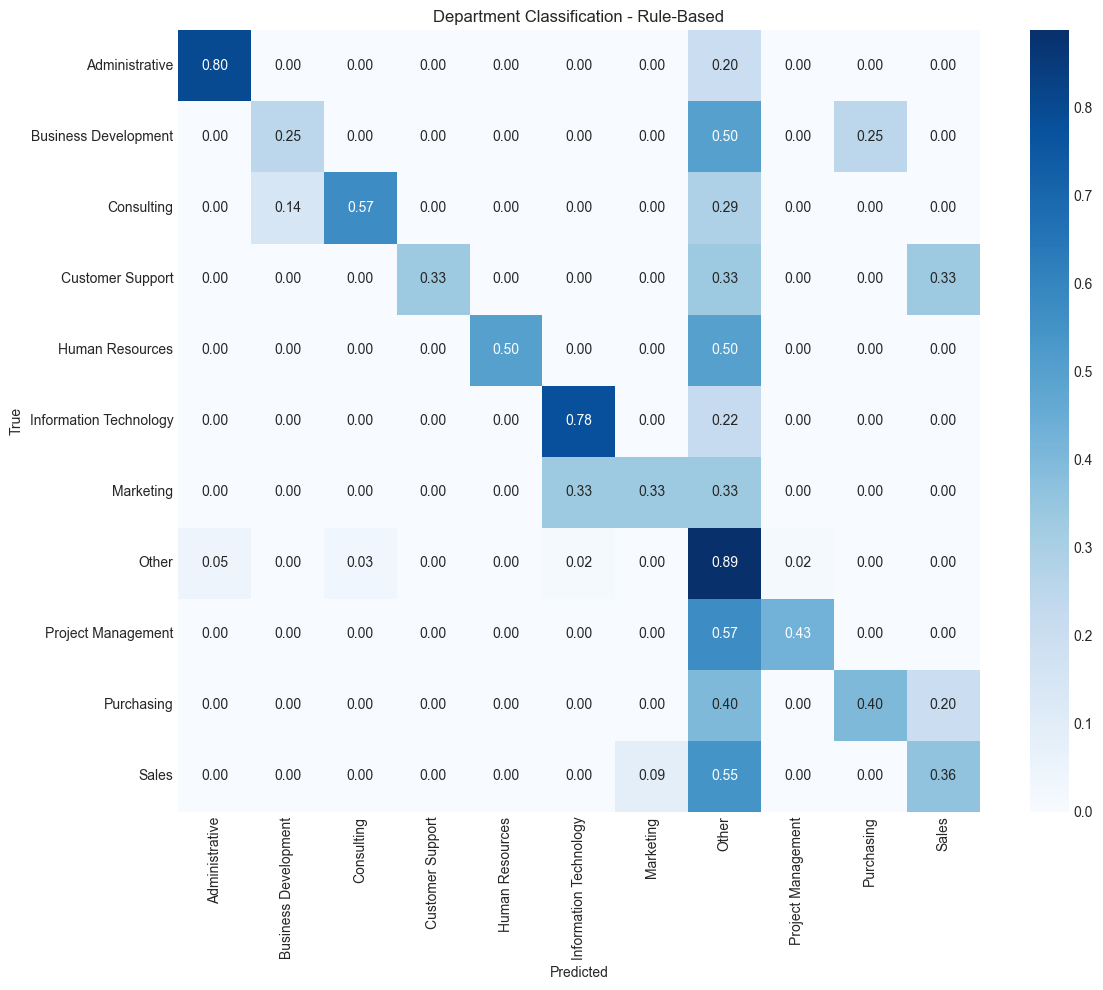

In [11]:
# Confusion matrix for department
fig = plot_confusion_matrix(
    test_df['department'].tolist(),
    hybrid_dept_preds,
    title="Department Classification - Rule-Based",
    figsize=(12, 10),
    normalize=True
)
plt.savefig('../reports/figures/rule_based_dept_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Seniority Classification

In [12]:
# Create seniority classifier
seniority_clf = create_seniority_classifier(seniority_df)

# Test examples
test_titles_seniority = [
    "CEO",
    "Senior Software Engineer",
    "Junior Analyst",
    "Team Lead",
    "Praktikant",  # German: Intern
    "Directeur",   # French: Director
]

print("Seniority predictions:")
for title in test_titles_seniority:
    pred, conf, method = seniority_clf.predict_single(title)
    print(f"  '{title}' -> {pred} (conf: {conf:.2f}, method: {method})")

Seniority predictions:
  'CEO' -> Management (conf: 1.00, method: exact)
  'Senior Software Engineer' -> Senior (conf: 1.00, method: exact)
  'Junior Analyst' -> Junior (conf: 0.50, method: substring)
  'Team Lead' -> Lead (conf: 0.60, method: keyword)
  'Praktikant' -> Junior (conf: 0.30, method: keyword)
  'Directeur' -> Director (conf: 0.30, method: keyword)


In [13]:
# Evaluate seniority on test set
seniority_preds = seniority_clf.predict(test_df['position'].tolist())

metrics_seniority = evaluate_predictions(test_df['seniority'].tolist(), seniority_preds)
print("Hybrid Matching - Seniority:")
for k, v in metrics_seniority.items():
    print(f"  {k}: {v:.3f}")

Hybrid Matching - Seniority:
  accuracy: 0.575
  f1_macro: 0.498
  f1_weighted: 0.597
  precision_macro: 0.515
  recall_macro: 0.548
  coverage: 1.000


In [14]:
# Seniority matching stats
stats_sen = seniority_clf.get_stats(test_df['position'].tolist())
print("\nSeniority matching method breakdown:")
total_sen = sum(stats_sen.values())
for method, count in stats_sen.items():
    print(f"  {method}: {count} ({count/total_sen*100:.1f}%)")


Seniority matching method breakdown:
  exact: 19 (15.0%)
  substring: 33 (26.0%)
  keyword: 37 (29.1%)
  default: 38 (29.9%)


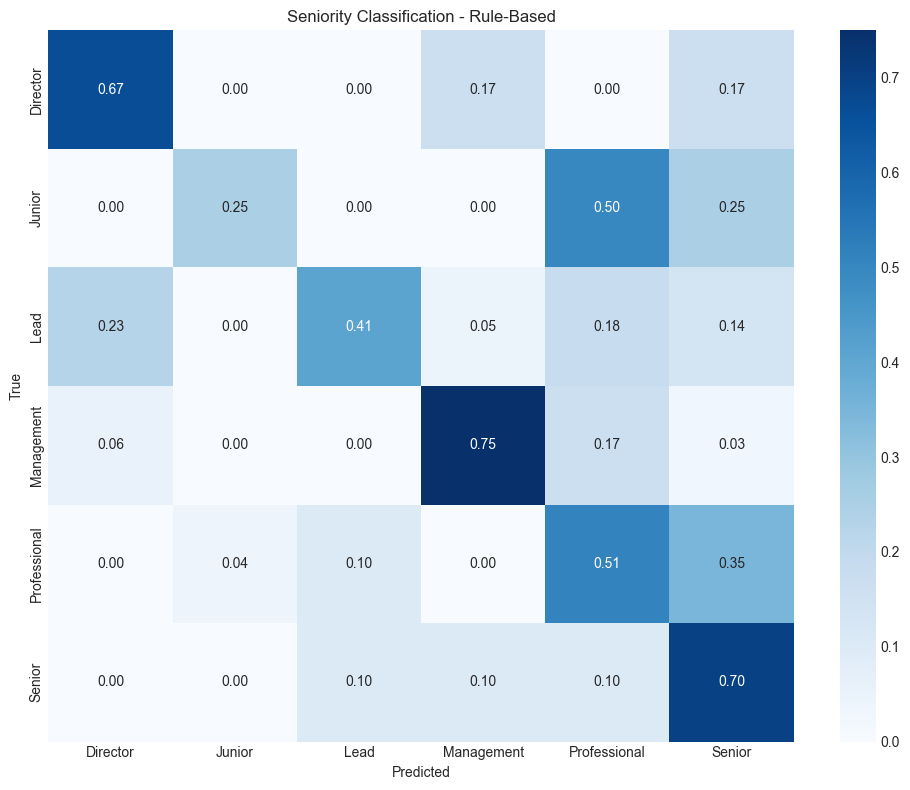

In [15]:
# Confusion matrix for seniority
fig = plot_confusion_matrix(
    test_df['seniority'].tolist(),
    seniority_preds,
    title="Seniority Classification - Rule-Based",
    figsize=(10, 8),
    normalize=True
)
plt.savefig('../reports/figures/rule_based_seniority_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Error Analysis

In [16]:
# Analyze department errors
print("=== Department Errors ===")
dept_errors = analyze_errors(
    test_df['position'].tolist(),
    test_df['department'].tolist(),
    hybrid_dept_preds,
    n_samples=15
)
dept_errors

=== Department Errors ===


,text,true_label,predicted_label
17,Digital Project Managerin Marketing,Marketing,Information Technology
13,CTO,Information Technology,Other
4,Member of the Advisory Board,Other,Consulting
29,Administrateur suppléant/ Membre des Commissio...,Other,Administrative
35,Advanced Purchasing - Commercial Vehicles and ...,Purchasing,Sales
25,Produktmanager Optomechanik,Project Management,Other
6,Director of Product Management,Project Management,Other
26,Director of Sales & Marketing,Sales,Marketing
24,Konsult HR,Human Resources,Other
16,Head of Startup Engagements for S/4HANA and Di...,Business Development,Purchasing


In [17]:
# Analyze seniority errors
print("=== Seniority Errors ===")
sen_errors = analyze_errors(
    test_df['position'].tolist(),
    test_df['seniority'].tolist(),
    seniority_preds,
    n_samples=15
)
sen_errors

=== Seniority Errors ===


,text,true_label,predicted_label
19,Business Consultant,Professional,Senior
49,Equipment Project Manager,Professional,Senior
48,"Facharzt für Orthopädie und Unfallchirurgie,Ch...",Professional,Senior
12,Managing Director,Management,Director
44,Bestuursassistent,Professional,Junior
5,Head of aws Preseed and Seedfinancing - Innova...,Lead,Director
17,Finance Director Central Europe 🇩🇪🇨🇭🇵🇱,Director,Management
52,Président CCRG Hauts de France,Management,Professional
3,Member of the Advisory Board,Management,Professional
32,Global Chief Engineer / Manager - Power Electr...,Lead,Management


## 6. Hyperparameter Tuning

Experiment with different configurations:

In [18]:
# Try different configurations
configs = [
    RuleConfig(use_exact_match=True, use_substring_match=False, use_keyword_match=False, default_label="Other"),
    RuleConfig(use_exact_match=True, use_substring_match=True, use_keyword_match=False, default_label="Other"),
    RuleConfig(use_exact_match=True, use_substring_match=True, use_keyword_match=True, default_label="Other"),
]

config_names = ["Exact only", "Exact + Substring", "Exact + Substring + Keywords"]

results = []
for name, config in zip(config_names, configs):
    clf = HybridRuleClassifier(
        label_df=department_df,
        keyword_dict=KeywordMatcher.DEPARTMENT_KEYWORDS,
        config=config
    )
    preds = clf.predict(test_df['position'].tolist())
    metrics = evaluate_predictions(test_df['department'].tolist(), preds)
    results.append({'config': name, **metrics})

results_df = pd.DataFrame(results)
results_df

,config,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro,coverage
0,Exact only,0.543307,0.171911,0.429581,0.411402,0.156500,1.0
1,Exact + Substring,0.590551,0.316759,0.508841,0.588755,0.266073,1.0
2,Exact + Substring + Keywords,0.708661,0.572888,0.690509,0.717512,0.513198,1.0


## 7. Summary

In [19]:
# Summary table
summary = pd.DataFrame([
    {'Task': 'Department', 'Accuracy': metrics_hybrid_dept['accuracy'], 
     'F1 (macro)': metrics_hybrid_dept['f1_macro'], 'Coverage': metrics_hybrid_dept['coverage']},
    {'Task': 'Seniority', 'Accuracy': metrics_seniority['accuracy'],
     'F1 (macro)': metrics_seniority['f1_macro'], 'Coverage': metrics_seniority['coverage']},
])

print("=== Rule-Based Baseline Results ===")
print(summary.to_string(index=False))

=== Rule-Based Baseline Results ===
      Task  Accuracy  F1 (macro)  Coverage
Department  0.708661    0.572888       1.0
 Seniority  0.574803    0.497614       1.0


## 8. Ideas for Improvement

To improve the rule-based baseline, you could:

1. **Expand keyword lists** - Add more multilingual keywords based on error analysis
2. **Add regex patterns** - For structured patterns like "Head of X" → Lead
3. **Normalize text** - Handle abbreviations, diacritics, etc.
4. **Use organization info** - Some organizations imply certain departments
5. **Hierarchical matching** - Try broader categories first, then refine

Try your own improvements in the cells below!

In [20]:
# Your experiments here
# Example: Add custom keywords

custom_keywords = KeywordMatcher.DEPARTMENT_KEYWORDS.copy()
custom_keywords['Sales'].extend(['akquisition', 'acquisition', 'client success'])

# Test with custom keywords
# ...